# Turing JL

## Turing Tutorials

# 5. Bayesian Neural Networks

**TuringLang contributors**

**Source:** https://turing.ml/dev/tutorials/02-logistic-regression/

In this notebook we will see how straightforward it is to implement a Bayesian neural network using the combined power of `Turing.jl` and `Flux.jl`.


In [1]:
using Turing
using Flux
using ReverseDiff
using Random
using Plots

Random.seed!(1234)

# Hide sampling progress.
Turing.setprogress!(false);
# Use reverse_diff due to the number of parameters in neural networks.
Turing.setadbackend(:reversediff)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/josinai/.julia/packages/Turing/YGtAo/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /home/josinai/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


:reversediff

### Hard to learn artificial dataset

We will classify points in an artificial dataset with a nonlinear decision boundary.

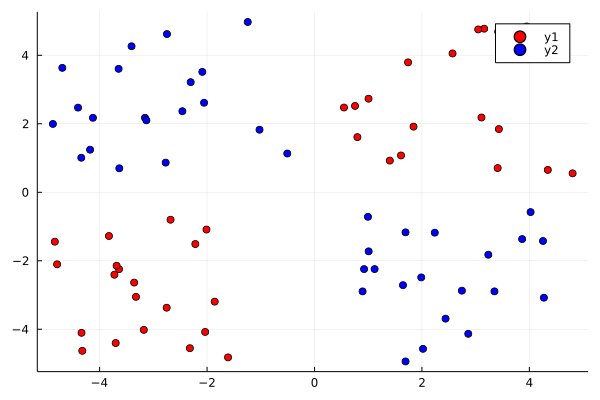

In [2]:
# Number of points to generate.
N = 80
M = round(Int, N / 4)

# Generate artificial data.
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all the data for later.
xs = [xt1s; xt0s]
ts = [ones(2*M); zeros(2*M)]

# Plot data points.
function plot_data()
    x1 = map(e -> e[1], xt1s)
    y1 = map(e -> e[2], xt1s)
    x2 = map(e -> e[1], xt0s)
    y2 = map(e -> e[2], xt0s)

    Plots.scatter(x1,y1, color="red", clim = (0,1))
    Plots.scatter!(x2, y2, color="blue", clim = (0,1))
end

plot_data()


### Simple neural network.

We will now build a neural network where the parameters will be expressed as distributions and not point objects as in standard neural networks. The two functions below, `unpack` and `nn_forward` are helper functions which we will need to specify the model in `Turing.jl`:

- `unpack` takes a vector of (in this case 20) parameters and partitions them between weights and bias vectors.
- `nn_forward` constructs a neural network using the variables generated in `unpack` and returns a prediction based on the weights provided.

Alternatively we can avoid using `unpack` by sampling the weights and bias vectors for each layer separately.

In [3]:
# Turn a vector into a set of weights and biases.
function unpack(nn_params::AbstractVector)
    W₁ = reshape(nn_params[1:6], 3, 2);   
    b₁ = nn_params[7:9]
    
    W₂ = reshape(nn_params[10:15], 2, 3); 
    b₂ = nn_params[16:17]
    
    Wₒ = reshape(nn_params[18:19], 1, 2); 
    bₒ = nn_params[20:20]
    return W₁, b₁, W₂, b₂, Wₒ, bₒ
end

# Construct a neural network using Flux and return a predicted value.
function nn_forward(xs, nn_params::AbstractVector)
    W₁, b₁, W₂, b₂, Wₒ, bₒ = unpack(nn_params)
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, b₂, tanh),
               Dense(Wₒ, bₒ, σ))
    return nn(xs)
end;


The probabalistic model specification below creates a `params` variable, which has 20 normally distributed variables. The entries in the `params` vector can be unpacked to form the weights and biases of the neural network according to the custom `unpack` function.

In [4]:
# Create a regularization term and a Gaussain prior variance term.
alpha = 0.09
sig = sqrt(1.0 / alpha)

# Specify the probabalistic model.
@model function bayes_nn(xs, ts)
    # Create the weight and bias vector.
    nn_params ~ MvNormal(zeros(20), sig .* ones(20))
    
    # Calculate predictions for the inputs given the weights
    # and biases in theta.
    preds = nn_forward(xs, nn_params)
    
    # Observe each prediction.
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end;


### Inference using MCMC

We will use Hamiltonian Monte Carlo to perform inference of the posterior distribution using sampling.

In [5]:
# Perform inference.
N = 5000
chain = sample(bayes_nn(hcat(xs...), ts), HMC(0.05, 4), N);


Now we extract the weights and biases from the sampled chain. We'll use these primarily in determining how good a classifier our model is.

In [7]:
# Extract all weight and bias parameters.
theta = MCMCChains.group(chain, :nn_params).value;

### Decision boundary

We can visualise how the neural network is able to learn a non-linear decision boundary. We will use MAP estimation using the log-probabilities stored in the chain.

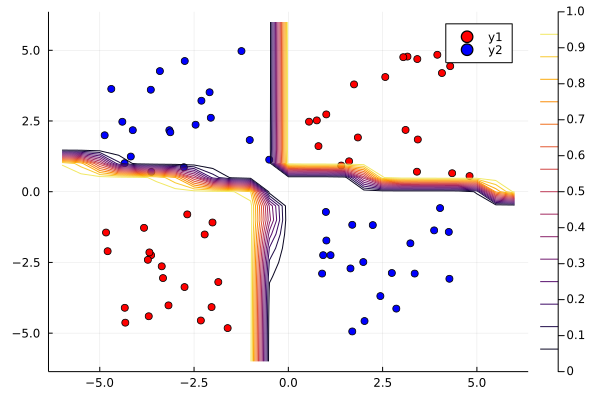

In [8]:
# Plot the data we have.
plot_data()

# Find the index that provided the highest log posterior in the chain.
_, i = findmax(chain[:lp])

# Extract the max row value from i.
i = i.I[1]   # i is a cartesian index object and .I accesses the index giving the argmax

# Plot the posterior distribution with a contour plot.
x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_forward([x, y], theta[i, :])[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

### Neural Network Predictions

Predictions are made using the posterior predictive distribution which we can estimate using our neural network. Recall that $\alpha$ is our regularization hyperparameter and therefore the neural network parameters are dependent on $\alpha$ as well as the data:

$$p(x | X, \alpha) = \int_{\theta}p(x|\theta)p(\theta | X, \alpha)d\theta \approx \sum_{\theta \sim p(\theta | X, \alpha)}f_{\theta}(x). $$

In [20]:
# Return the average predicted value across multiple drawn weights.
function nn_predict(x, theta, num)
    mean([nn_forward(x, theta[i,:])[1] for i in 1:10:num])
end;

Next, we use the `nn_predict` function to predict the value at a sample of points where the x and y coordinates range between -6 and 6. As we can see below, we still have a satisfactory fit to our data.

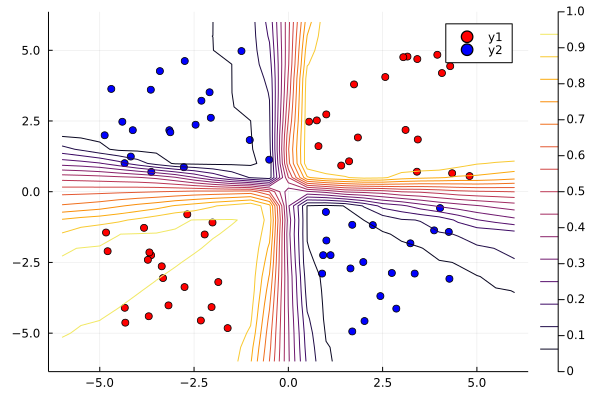

In [21]:
# Plot the average prediction.
plot_data()

n_end = 1500
x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_predict([x, y], theta, n_end)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

We can also nearly animate the training process:

┌ Info: Saved animation to 
│   fn = /mnt/c/Users/josinai/workspace/JuliaPlayground/TuringJL/tmp.gif
└ @ Plots /home/josinai/.julia/packages/Plots/avj9X/src/animation.jl:104


Plots.AnimatedGif("/mnt/c/Users/josinai/workspace/JuliaPlayground/TuringJL/tmp.gif")
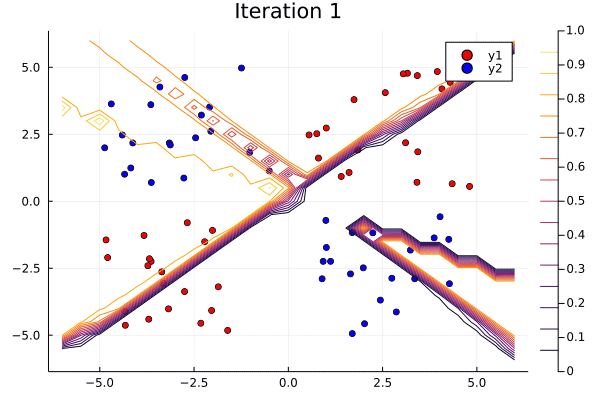

In [22]:
# Number of iterations to plot.
n_end = 500

anim = @gif for i=1:n_end
    plot_data()
    Z = [nn_forward([x, y], theta[i,:])[1] for x=x_range, y=y_range]
    contour!(x_range, y_range, Z, title="Iteration $i", clim = (0,1))
end every 5

## Generic Bayesian Neural Network

The BNN we created above used pretty rigid code, eg `unpack`. The code below let's us specify more flexible feedforward neural networks.

In [27]:
# Specify the network architecture using tuples: (output_dim, input_dim, nonlinearity)
network_shape = [
    (3,2, :tanh),
    (2,3, :tanh), 
    (1,2, :σ)]

# Regularization, parameter variance, and total number of
# parameters.
α = 0.09
σ² = sqrt(1.0 / α)
num_params = sum([i * o + i for (i, o, _) in network_shape])

# This modification of the unpack function generates a series of vectors
# given a network shape.
function unpack(θ::AbstractVector, network_shape::AbstractVector)
    index = 1
    weights = []
    biases = []
    for layer in network_shape
        rows, cols, _ = layer
        size = rows * cols
        last_index_w = size + index - 1
        last_index_b = last_index_w + rows
        push!(weights, reshape(θ[index:last_index_w], rows, cols))
        push!(biases, reshape(θ[last_index_w+1:last_index_b], rows))
        index = last_index_b + 1
    end
    return weights, biases
end

# Generate an abstract neural network given a shape, 
# and return a prediction.
function nn_forward(x, θ::AbstractVector, network_shape::AbstractVector)
    weights, biases = unpack(θ, network_shape)
    layers = []
    for i in eachindex(network_shape)
        push!(layers, 
            Dense(weights[i], biases[i], eval(network_shape[i][3]))
        )
    end
    nn = Chain(layers...)
    return nn(x)
end

# General Turing specification for a BNN model.
@model bayes_nn_general(xs, ts, network_shape, num_params) = begin
    θ ~ MvNormal(zeros(num_params), σ² .* ones(num_params))
    preds = nn_forward(xs, θ, network_shape)
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end

# Perform inference.
num_samples = 500
new_chain = sample(bayes_nn_general(hcat(xs...), ts, network_shape, num_params), NUTS(0.65), num_samples);


┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/josinai/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/josinai/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/josinai/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/josinai/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47


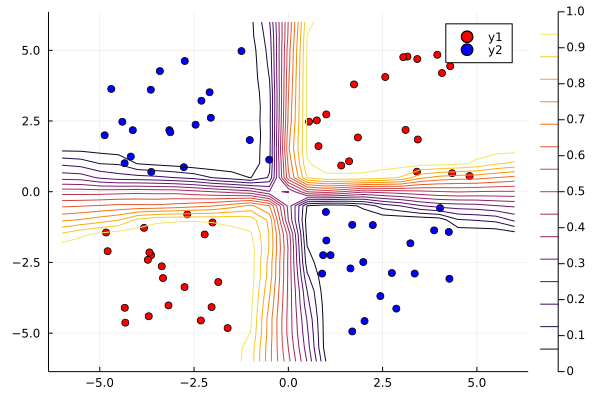

In [28]:
# This function makes predictions based on network shape.
function nn_predict(x, theta, num, network_shape)
    mean([nn_forward(x, theta[i,:], network_shape)[1] for i in 1:10:num])
end;

# Extract the θ parameters from the sampled chain.
params2 = MCMCChains.group(new_chain, :θ).value

plot_data()

x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_predict([x, y], params2, length(new_chain), network_shape)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)